In [1]:
Threads.nthreads()

8

In [2]:
using DifferentialEquations
using Plots
using DifferentialEquations.EnsembleAnalysis
using DiffEqGPU, OrdinaryDiffEq, CUDA

In [3]:
function cancitis_rhs(du, u, p, t)
    # defines the right-hand side of the original cancitis model as defined in the PLOS One paper from 2017
    # for now only allows constant external inflammatory load I (last entry in p)
    rx, ry, ax, ay, Ax, Ay, dx0, dy0, dx1, dy1, dy0t, cxx, cxy, cyx, cyy, es, rs, ea, rm, I = p
    x0, x1, y0, y1, a, s = u
    phix = 1/(1+(cxx*x0 + cxy*y0)^2)
    phiy = 1/(1+(cyx*x0 + cyy*y0)^2)
    du[1] = (rx * phix * s - dx0 - ax - rm*s)*x0
    du[2] = ax*Ax*x0 - dx1*x1
    du[3] = (ry * phiy * s - dy0 - ay)*y0 + rm*s*x0
    du[4] = ay*Ay*y0 - dy1*y1
    du[5] = dx0*x0 + dx1*x1 + dy0*y0 + dy1*y1 - ea*s*a
    du[6] = rs*a - es*s + I
end

function rhs_factory(I_function)
    # produces a callable function that implements the cancitis right-hand side with time-dependent inflammatory load
    # takes as input a callable function I_function(t) that gives the inflammatory load at time t
    function cancitis_rhs(du, u, p, t)
        # defines the right-hand side of the original cancitis model as defined in the PLOS One paper from 2017
        # for now only allows constant external inflammatory load I (last entry in p)
        rx, ry, ax, ay, Ax, Ay, dx0, dy0, dx1, dy1, dy0t, cxx, cxy, cyx, cyy, es, rs, ea, rm, I = p
        x0, x1, y0, y1, a, s = u
        phix = 1/(1+(cxx*x0 + cxy*y0)^2)
        phiy = 1/(1+(cyx*x0 + cyy*y0)^2)
        du[1] = (rx * phix * s - dx0 - ax - rm*s)*x0
        du[2] = ax*Ax*x0 - dx1*x1
        du[3] = (ry * phiy * s - dy0 - ay)*y0 + rm*s*x0
        du[4] = ay*Ay*y0 - dy1*y1
        du[5] = dx0*x0 + dx1*x1 + dy0*y0 + dy1*y1 - ea*s*a
        du[6] = rs*a - es*s + I_function(t)
    end
end


function dimensional_reduced_cancitis_rhs(du, u, p, t)
    rx, ry, ax, ay, Ax, Ay, dx0, dy0, dx1, dy1, dy0t, cxx, cxy, cyx, cyy, es, rs, ea, rm, I = p
    x0, y0 = u
    x1 = ax*Ax*x0/dx1
    y1 = ay*Ay*y0/dy1
    phix = 1/(1+(cxx*x0 + cxy*y0)^2)
    phiy = 1/(1+(cyx*x0 + cyy*y0)^2)
    kappa = dx0*x0 + (dy0t*y0 + dy0)*y0 + dx1*x1 + dy1*y1
    a = 0.5*sqrt((I/rs)^2 + 4*es*kappa/(ea*rs)) - I/(2*rs)
    s = rs*a/es + I/es
    du[1] = (rx*phix*s - dx0 - ax)*x0 - rm*s*x0
    du[2] = (ry*phiy*s - dy0 - dy0t*y0 - ay)*y0 + rm*s*x0
end


function cancitis_noise(du, u, p, t)
    # defines the noise amplitude for the cancitis model.
    # for the stem cells, take multiplicative noise with a scale 1/sqrt(N) where N=1e5 is the number of stem cells
    # let's just leave that as the only source of uncertainty for now
    du[1] = u[1]/sqrt(1e5)
    du[3] = u[3]/sqrt(1e5)
end

function reduced_cancitis_noise(du, u, p, t)
    du[1] = u[1]/sqrt(1e5)
    du[2] = u[2]/sqrt(1e5)
end

reduced_cancitis_noise (generic function with 1 method)

In [4]:
u0 = [1.01e4, 3.84e10, 0, 0, 699, 3.61]
p = [8.7e-4, 1.5e-3, 1.1e-5, 1.1e-5, 4.7e13, 4.7e13, 2e-3, 2e-3, 129, 129, 2e-9, 7.5e-5, 7.5e-5, 7.5e-5, 7.5e-5, 2, 3e-4, 2e9, 2e-8, 7]
du = zeros(6)
t=0
# call the rhs function once to precompile it
cancitis_rhs(du, u0, p, t)
cancitis_noise(du, u0, p, t)
t_relax = 2.5e3
t_final=365*80

# solve the ODE to relax hopefully out of a stiff region
ode_prob = ODEProblem(cancitis_rhs, u0, (0, t_final), p)
ode_sol = solve(ode_prob, saveat=365)

# solve the reduced problem to compare
u0_reduced = [u0[1], u0[3]]
reduced_prob = ODEProblem(dimensional_reduced_cancitis_rhs, u0_reduced, (0, t_final), p)
reduced_sol = solve(reduced_prob, saveat=365)

# write a callback to enforce nonnegativity
condition(u, t, integrator) = any([uu >=0 for uu in u])
affect!(integrator) = clamp!(integrator.u, 0, Inf)
cb = DiscreteCallback(condition, affect!, save_positions=(false, false))

prob = SDEProblem(dimensional_reduced_cancitis_rhs, reduced_cancitis_noise, u0_reduced, (0, t_final), p)

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\jordan\.julia\packages\SciMLBase\JKXkh\src\integrator_interface.jl:589


SDEProblem with uType Vector{Float64} and tType Int64. In-place: true
Non-trivial mass matrix: false
timespan: (0, 29200)
u0: 2-element Vector{Float64}:
 10100.0
     0.0

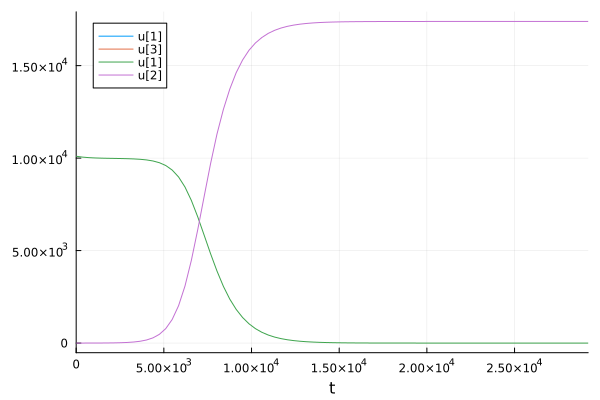

In [5]:
plot(ode_sol, idxs = [1,3])
plot!(reduced_sol)

In [6]:
sol = solve(prob, ImplicitEM(), callback=cb, saveat=30)

retcode: Success
Interpolation: 1st order linear
t: 975-element Vector{Float64}:
     0.0
    30.0
    60.0
    90.0
   120.0
   150.0
   180.0
   210.0
   240.0
   270.0
     ⋮
 28980.0
 29010.0
 29040.0
 29070.0
 29100.0
 29130.0
 29160.0
 29190.0
 29200.0
u: 975-element Vector{Vector{Float64}}:
 [10100.0, 0.0]
 [9925.981791934, 0.022674708281128685]
 [10227.650260958852, 0.04661198747919542]
 [9920.572345220757, 0.0691326616908097]
 [9844.26606507376, 0.09386280189863803]
 [9978.872571023261, 0.11846573306042557]
 [9794.184770127596, 0.14469717854243958]
 [10019.084529140388, 0.17270762120221814]
 [10276.564671486763, 0.20201418224663537]
 [10295.330303298126, 0.23355374182418714]
 ⋮
 [0.0001137911151021118, 17721.053044017728]
 [0.00010766558957391141, 17325.366065539154]
 [0.00010769611900964614, 18177.882019651595]
 [0.00010452050333798678, 18259.73081892977]
 [0.00010233589206251659, 17861.917287640532]
 [9.894017490123218e-5, 17830.013669367603]
 [9.714361787523821e-5, 17867.16

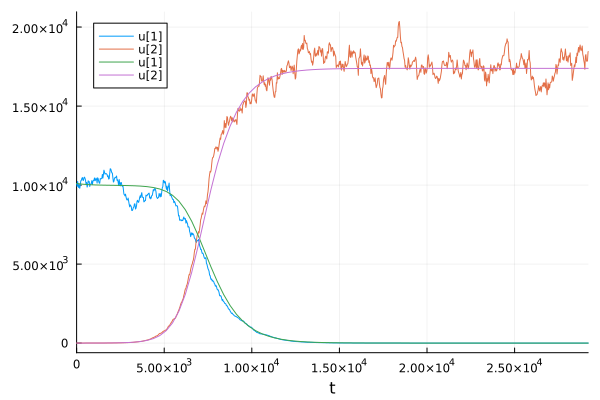

In [7]:
plot(sol)
plot!(reduced_sol)

In [8]:
ensembleprob = EnsembleProblem(prob)
sol = solve(ensembleprob, ImplicitEM(), EnsembleThreads(), trajectories = 1000, callback=cb, saveat=30)

EnsembleSolution Solution of length 1000 with uType:
RODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, NoiseProcess{Float64, 2, Float64, Vector{Float64}, Nothing, Nothing, typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_DIST), typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_BRIDGE), Nothing, true, ResettableStacks.ResettableStack{Tuple{Float64, Vector{Float64}, Nothing}, true}, ResettableStacks.ResettableStack{Tuple{Float64, Vector{Float64}, Nothing}, true}, RSWM{Float64}, Nothing, RandomNumbers.Xorshifts.Xoroshiro128Plus}, Nothing, SDEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, Nothing, SDEFunction{true, SciMLBase.FullSpecialize, typeof(dimensional_reduced_cancitis_rhs), typeof(reduced_cancitis_noise), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing}, typeof(reduced_cancitis_nois

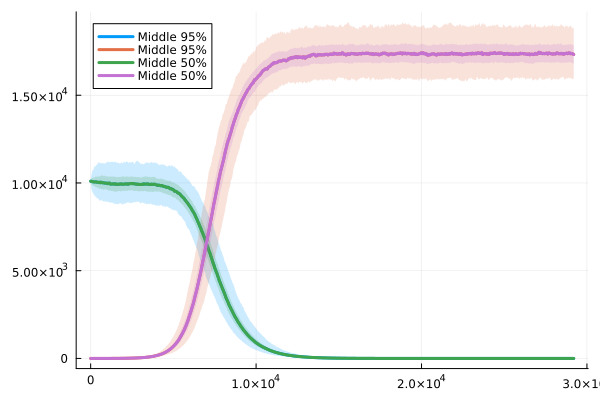

In [9]:
using DifferentialEquations.EnsembleAnalysis
summ = EnsembleSummary(sol; quantiles = [0.025, 0.975])
plot(summ, labels = "Middle 95%")
summ = EnsembleSummary(sol; quantiles = [0.25, 0.75])
plot!(summ, labels = "Middle 50%", legend = true)

In [10]:
t = sol[1].t
U = [s.u for s in sol]

1000-element Vector{Vector{Vector{Float64}}}:
 [[10100.0, 0.0], [10148.876976607084, 0.02257385414931226], [9956.259645445209, 0.046647967136536246], [10036.348528885426, 0.07123163146507833], [9992.089385678135, 0.09843664431724959], [9809.574107523951, 0.1283581611658474], [9695.339398215467, 0.15225173158057345], [9991.767226863782, 0.18357253039671684], [10070.519612819935, 0.20770418767338458], [10227.385273153075, 0.23974126163944892]  …  [6.576434347703708e-5, 17663.457443061503], [6.38580870721359e-5, 17504.332756745018], [6.287454339576653e-5, 17245.977609266003], [6.211735379751101e-5, 17436.340172139317], [6.139649173610574e-5, 17451.33906285708], [5.8643322639336784e-5, 17369.642953517592], [5.4355465075834584e-5, 16942.530620355406], [5.273048701741421e-5, 17037.737621663102], [5.2715477024602164e-5, 17508.701867279913], [5.1252261425044525e-5, 17477.00630740272]]
 [[10100.0, 0.0], [10115.519147362571, 0.022323351926149697], [10358.468911395452, 0.04545009635498128], [1064

In [ ]:
cat(cat(U...; dims=2)...;dims=3)

In [ ]:
sol[1].u

In [ ]:
# try with static vectors to see if i can get it to run on the GPU


function dimensional_reduced_cancitis_rhs(u, p, t)
    # out-of-place version with static vectors
    rx, ry, ax, ay, Ax, Ay, dx0, dy0, dx1, dy1, dy0t, cxx, cxy, cyx, cyy, es, rs, ea, rm, I = p
    x0, y0 = u
    x1 = ax*Ax*x0/dx1
    y1 = ay*Ay*y0/dy1
    phix = 1/(1+(cxx*x0 + cxy*y0)^2)
    phiy = 1/(1+(cyx*x0 + cyy*y0)^2)
    kappa = dx0*x0 + (dy0t*y0 + dy0)*y0 + dx1*x1 + dy1*y1
    a = 0.5*sqrt((I/rs)^2 + 4*es*kappa/(ea*rs)) - I/(2*rs)
    s = rs*a/es + I/es
    du1 = (rx*phix*s - dx0 - ax)*x0 - rm*s*x0
    du2 = (ry*phiy*s - dy0 - dy0t*y0 - ay)*y0 + rm*s*x0
    return SVector{2}(du1, du2)
end

function reduced_cancitis_noise(u, p, t)
    # out of place version with static vectors
    return SVector{2}(u[1]/sqrt(1e5), u[2]/sqrt(1e5))
end

u0 = @SVector [1.01f4, 0f0]
p = @SVector [8.7f-4, 1.5f-3, 1.1f-5, 1.1f-5, 4.7f13, 4.7f13, 2f-3, 2f-3, 129, 129, 2f-9, 7.5f-5, 7.5f-5, 7.5f-5, 7.5f-5, 2, 3f-4, 2f9, 2f-8, 7]
t_final=365f0*80f0
tspan = (0f0, t_final)
# call the rhs function once to precompile it

prob = SDEProblem{false}(dimensional_reduced_cancitis_rhs, reduced_cancitis_noise, u0, tspan, p)
ens_prob = EnsembleProblem(prob)

In [ ]:
sol = solve(ens_prob, SRIW1(), DiffEqGPU.EnsembleGPUArray(), trajectories = 10000, saveat = 30)

In [ ]:
summ = EnsembleSummary(sol; quantiles = [0.1, 0.9])
plot(summ)

In [ ]:
CUDA.device()